In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from models import *
from plots_lstm import *
from preprocessing_data import *

from tensorflow import keras 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import CSVLogger, EarlyStopping
import tensorflow as tf
import tensorflow.keras.backend as K

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
tf.debugging.set_log_device_placement(False)

Num GPUs Available:  1


In [4]:
def getPredictionModel(model_type):
    features =  [
                        model_type,'price', 'isWeekend', 
                        'isHoliday',  'temp', 'wind','day_cos', 'day_sin',
                        ]
    past_history = 192 # 2days
    future_target = 16 # 4hours
    STEP = 1
    TRAIN_SPLIT = 34000
    BUFFER_SIZE = 2000
    BATCH_SIZE = 1
    EPOCHS = 100
    EVALUATION_INTERVAL = 100
    train_data, val_data, x_train, y_train = preprocess_data_for_LSTM(
        df, 
        features, 
        past_history,
        future_target,
        STEP,
        TRAIN_SPLIT,
        BATCH_SIZE,
        BUFFER_SIZE)
    n_timesteps = x_train.shape[-2:][0]
    n_features = x_train.shape[-2:][1]
    model = build_model_BasicLSTM_OneLayer(n_timesteps,n_features,future_target)

    early_stopping = EarlyStopping(monitor='val_loss', patience = 6, restore_best_weights=True)
    history = model.fit(
                                    train_data,
                                    epochs=EPOCHS,
                                    steps_per_epoch=EVALUATION_INTERVAL,
                                    validation_data=val_data,
                                    validation_steps=EVALUATION_INTERVAL,
                                    callbacks=[early_stopping]
                                    )
    
    return model

In [5]:
df = pd.read_csv("../data/data_processed.csv")
df['date'] = pd.to_datetime(df['date'], format='%Y/%m/%d %H:%M')

df['fve'] = df['fve'] * 0.03
df['mve'] = df['mve'] * 0.07
df['wpg'] = df['wpg'] * 0.07

df['production_usage'] = df['fve'] + df['mve'] + df['wpg'] 
df['production_usage'] = df['production_usage'].fillna(df['production_usage'].median())

In [6]:
production_model = getPredictionModel("production_usage")
consumption_model = getPredictionModel("consumption_usage")

(33808, 192, 8)
(33808, 16)
Single window of past history : (192, 8)
Target usage to predict : (16,)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 32)                5248      
_________________________________________________________________
dense (Dense)                (None, 16)                528       
Total params: 5,776
Trainable params: 5,776
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
100/100 [==============================] - 5s 39ms/step - loss: 0.2952 - val_loss: 1.2927
Epoch 2/100
100/100 [==============================] - 4s 40ms/step - loss: 0.1361 - val_loss: 1.4927
Epoch 3/100
100/100 [==============================] - 4s 39ms/step - loss: 0.1045 - val_loss: 1.7734
Epoch 4/100
100/100 [==============================] - 4s 40ms/step - loss: 0.0500 - val_loss: 1.5362
Ep

In [7]:
def preprocessing_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])

        if single_step:
            labels.append(target[i+target_size])
        else:
            labels.append(target[i:i+target_size])

    return np.array(data, dtype=np.float32), np.array(labels, dtype=np.float32)

def preprocess_data_for_prediction(df,features,past_history, future_target, STEP, TRAIN_SPLIT,BATCH_SIZE,BUFFER_SIZE):
    features = df[features]
    features.index = df['date']    
    dataset = features.values
    data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
    data_std = dataset[:TRAIN_SPLIT].std(axis=0)
    dataset = (dataset-data_mean)/data_std
    
    X, y = preprocessing_data(dataset, dataset[:, 0], 0,
                                                 None, past_history,
                                                 future_target, STEP,single_step=True)
    predict_data = tf.data.Dataset.from_tensor_slices((X, y))
    predict_data = predict_data.cache().batch(BATCH_SIZE).repeat()
    return predict_data

In [8]:
features =  [
                        'production_usage','price', 'isWeekend', 
                        'isHoliday',  'temp', 'wind','day_cos', 'day_sin',
                        ]
past_history = 192 # 2days
future_target = 16 # 4hours
STEP = 1
TRAIN_SPLIT = 34000
BUFFER_SIZE = 2000
BATCH_SIZE = 1
EPOCHS = 100
EVALUATION_INTERVAL = 100
predict_data = preprocess_data_for_prediction(df,features,past_history,future_target,STEP,TRAIN_SPLIT,BATCH_SIZE,BUFFER_SIZE)

In [9]:
for x in predict_data.take(1):
    data = production_model(x)
    print(data)

ValueError: Layer sequential expects 1 input(s), but it received 2 input tensors. Inputs received: [<tf.Tensor: shape=(1, 192, 8), dtype=float32, numpy=
array([[[ 7.0814991e-01, -3.7813399e-02, -6.3162225e-01, ...,
         -2.1744972e-01,  1.4134283e+00, -2.4393186e-04],
        [ 9.3337321e-01, -3.7813399e-02, -6.3162225e-01, ...,
         -2.1744972e-01,  1.4134283e+00, -2.4393186e-04],
        [ 9.1028166e-01, -3.7813399e-02, -6.3162225e-01, ...,
         -2.1744972e-01,  1.4134283e+00, -2.4393186e-04],
        ...,
        [ 1.1346540e+00, -4.4566891e-01, -6.3162225e-01, ...,
         -6.1639696e-01,  1.3652468e+00, -3.6632031e-01],
        [ 1.1350648e+00, -4.4566891e-01, -6.3162225e-01, ...,
         -6.1639696e-01,  1.3652468e+00, -3.6632031e-01],
        [ 1.1520437e+00, -4.4566891e-01, -6.3162225e-01, ...,
         -6.1639696e-01,  1.3652468e+00, -3.6632031e-01]]], dtype=float32)>, <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.032703], dtype=float32)>]

In [ ]:
#https://towardsdatascience.com/unsupervised-learning-and-data-clustering-eeecb78b422a
# https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
# https://scikit-learn.org/stable/modules/mixture.html
# https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html#sklearn.cluster.AgglomerativeClustering

In [59]:
df

,date,shops,office_building,industrial_park,fve,mve,wpg,price,isWeekend,isHoliday,...,temp,wind,hour,day,month,day_cos,day_sin,timestamp,month_cos,month_sin
0,2020-01-01 00:00:00,17.804000,40.560,18.040000,0.0,189.5740,6.3084,33.20,0,1,...,-8.0,3,0,1,1,1.000000,0.000000,1.577837e+09,0.999963,-0.008601
1,2020-01-01 00:15:00,12.960000,42.120,17.132000,0.0,205.7342,6.2678,33.20,0,1,...,-8.0,3,0,1,1,1.000000,0.000000,1.577838e+09,0.999965,-0.008422
2,2020-01-01 00:30:00,12.940000,41.808,16.244000,0.0,204.6569,5.6924,33.20,0,1,...,-8.0,3,0,1,1,1.000000,0.000000,1.577839e+09,0.999966,-0.008243
3,2020-01-01 00:45:00,13.100000,41.808,15.964000,0.0,203.9996,5.2423,33.20,0,1,...,-8.0,3,0,1,1,1.000000,0.000000,1.577840e+09,0.999967,-0.008064
4,2020-01-01 01:00:00,17.800000,41.808,20.932000,0.0,206.7842,5.1702,30.40,0,1,...,-8.4,3,1,1,1,0.965926,0.258819,1.577840e+09,0.999969,-0.007884
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35035,2020-12-09 22:45:00,19.153738,43.992,12.558862,0.0,58.7412,12.8317,42.27,0,0,...,5.7,7,22,9,12,0.866025,-0.500000,1.607554e+09,0.930490,-0.366318
35036,2020-12-09 23:00:00,11.461773,45.552,9.403881,0.0,58.5578,12.4789,35.30,0,0,...,5.4,7,23,9,12,0.965926,-0.258819,1.607555e+09,0.930555,-0.366151
35037,2020-12-09 23:15:00,11.461773,45.240,9.403881,0.0,58.1350,12.5286,35.30,0,0,...,5.4,7,23,9,12,0.965926,-0.258819,1.607556e+09,0.930621,-0.365984
35038,2020-12-09 23:30:00,11.461773,44.304,9.403881,0.0,58.7006,12.0876,35.30,0,0,...,5.4,7,23,9,12,0.965926,-0.258819,1.607557e+09,0.930687,-0.365818


# Kmeans

In [13]:
from sklearn.cluster import KMeans

features =  [
                        'production_usage','price', 'isWeekend', 
                        'isHoliday',  'temp', 'wind','day_cos', 'day_sin','month_cos','month_sin'
                        ]

X = df[features]
kmeans = KMeans(n_clusters=3, random_state=0).fit(X)
predict = kmeans.predict(X)
X['clusters'] = predict


<ipython-input-13-4271d807d519>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['clusters'] = predict


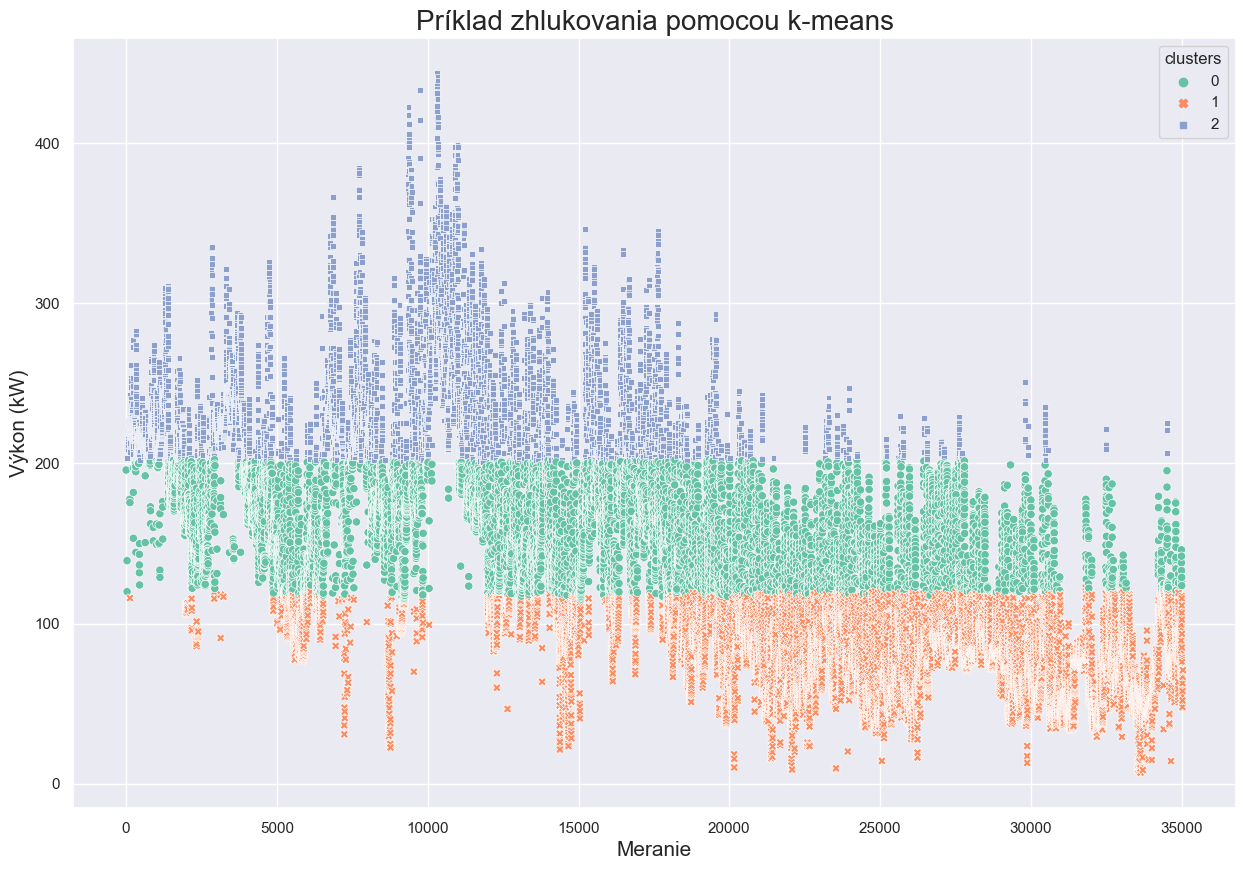

In [73]:
import seaborn as sns # '0.9.0'

sns.set(rc={'figure.figsize':(15,10)})
p  = sns.scatterplot(data=X, y='production_usage', x=X.index, style='clusters',hue='clusters',palette="Set2")
p.set_ylabel("Výkon (kW)", fontsize = 15)
p.set_xlabel("Meranie", fontsize = 15)
p.set_title("Príklad zhlukovania pomocou k-means", fontsize=20)
plt.show()